# 🧮 Design and save early larval morphologies 
This is a graphical interface for designing and saving early larval forms for exploring swimming and stability characteristics with the pyVRS (Python Volume-Rendered Swimmer) model of low-Reynolds number hydrodynamics. It has a simplified interface for entering parameters to investigate stability and movement of early-stage larval morphologies (e.g., eggs, blastulae and gastrulae) approximated by "chimeras" of semi-spheroids. These early larval shapes are constructed by joining two half-spheroids about a common central radius. 

By choosing different spheroid shapes (larger vs. smaller central radii; longer vs. shorter semi-spheroids, etc.) you can construct different surface shapes that resemble the outside surfaces of early stages in larval development. You can assign the main volume inside this surface to have a density that reflects the larval tissue within this surface. 

You can also add inclusions, constructed from two half-spheroids, to reflect the inner structure of early stage larvae. You can assign different densities to model the effects of internal volumes of these inclusions, to reflect whether they are filled with seawater, calcium carbonate, lipid, or other materials.

The resulting shapes do not represent any particular species and stage exactly, but they approximate early stages including eggs, gastrulae and blastulae from a wide diversity of species, and an even wider diversity of hypothetical larval morphologies that do not appear in nature. This makes these shapes good tools for exploring the consequences of size, morphological and physiological features, and properties of the fluid environment such as shear.

## How to use this notebook
This notebook is set up with "cells" that contain either Python code or explanatory text. You can see the cells by the bars and numbers on the left side of the notebook window.
- **To set up the codes for exploring early stage larval morphology, pull down the `Run` menu and select `Run All Cells`**

### Executing Jupyter notebook cells
- **To execute a code cell, select it and hold down the shift key while typing the `enter` key.**
- **To reset the model to its initial state, pull down the `Run` menu and select `Restart Kernel and Run All Cells`**

### Using graphics output
When the model starts, it creates a larval shape using default parameters. That shape is shown in a separate, resizable graphics window. You can:
- **Click and drag on graphics windows to control the viewing angle.**
- **Click on the floppy disk icon to save graphics windows as images. Use informative names like `default_shape.svg` so that you can tell one image from another later on.**

### Selecting a larval shape
Below, you can adjust geometrical parameters to select a larval shape:
- [Use input boxes to modify a shape or define a new one, and then calculate its hydrodynamic properties](#section_defshape)

Experiment by changing one or more geometrical parameters, and plotting the result.

When you have a morphology that you are interested in simulating, **save that shape to a file** which you can import into the `ChimeraSwim` simulation.
-  [Save a file containing the current shape for use in a future session](#section_saveshape)



In [1]:
# Set up graphics environment
#%matplotlib inline
#%matplotlib notebook
#import IPython
%matplotlib widget
#%matplotlib ipympl
from matplotlib import pyplot
pyplot.ioff()
#pyplot.ion()
from mpl_interactions import ipyplot as iplt
from mpl_toolkits import mplot3d
from matplotlib.colors import LightSource
# Import modules
import numpy as np
from math import pi
import os
# set up path to submodules
import sys
#sys.path.append('../../../submodules/')
#sys.path.append('../../../submodules/pyVRS')
import pyVRSmorph as mrph
import pyVRSflow as flw
from meshSpheroid import chimeraSpheroid
# Import widget infrastructure
from ipywidgets import interact, interactive, fixed, interact_manual, Output
import ipywidgets as widgets
from IPython import display as idisplay
import pickle
from ipyfilechooser import FileChooser
from copy import deepcopy

In [2]:
# Create a class and global instances for morphology parameters
global surf_pars, incl1_pars, incl2_pars
class CEpars():
    """
    A simple class to facilitate acquiring and passing chimera ellipsoid
    parameters with interactive_output widgets.
    """
    def __init__(self,D=50.e-6,L1=100.e-6,L2=-40.e-6,d=6e-6,nlevel0=16,nlevel1=12,
                      translate0=0.,translate1=0.,translate2=0.):
        self.D = D
        self.L1 = L1
        self.L2 = L2
        self.Ls = [L1,L2]
        self.d = d
        self.nlevels = [nlevel0,nlevel1]
        self.translate = [translate0,translate1,translate2]

def set_surf_pars(D,L1,L2,d,nlevel0,nlevel1):
    global surf_pars
    surf_pars=CEpars(D=D,L1=L1,L2=L2,d=d,nlevel0=nlevel0,nlevel1=nlevel1)

def set_incl1_pars(D,L1,L2,d,nlevel0,nlevel1,translate0,translate1,translate2):
    global incl1_pars
    incl1_pars=CEpars(D=D,L1=L1,L2=L2,d=d,nlevel0=nlevel0,nlevel1=nlevel1,
                      translate0=translate0,translate1=translate1,translate2=translate2)

def set_incl2_pars(D,L1,L2,d,nlevel0,nlevel1,translate0,translate1,translate2):
    global incl2_pars
    incl2_pars=CEpars(D=D,L1=L1,L2=L2,d=d,nlevel0=nlevel0,nlevel1=nlevel1,
                      translate0=translate0,translate1=translate1,translate2=translate2)

<hr style="border:10px solid red">

## To design a new larval shape: <a id='section_defshape'></a>
- **Scroll to the shape parameter input boxes (there are separate parameter sets for the larval surface and inclusions).**
- **Change one or more shape parameters, and re-execute the code cell below to calculate and visualize the shape.**
- **When you are satisfied with the shape, re-execute the next code cells to recalculate flow around the new shapes.**
- **Run the simulation as before, with `Reset` to create a new simulation window and `Run` to visualize swimming trajectories.**

### Define the outer larval shape 
![alt text](ChimeraSpheroid_geometry2.png "Surface shape parameters")

The text boxes below enable you to set the shape parameters for the outside of a model larva. To change parameters, enter a new value and hit `enter`. The parameters are:
- $D$: central diameter
- $L_1$: length of the top semi-ellipse (distance from the upper tip to the equator)
- $L_2$: length of the bottom semi-ellipse (distance from the lower tip to the equator)

Additional parameters (that you may not have to adjust) specify the layout of triangles on the larval surface. 
- $d$, a parameter specifying the number of columns of triangles on the top and bottom parts of the larval surface 
- $n_0$ and $n_1$ specify the number of rows of triangles on the top and bottom parts of the larval surface


In [3]:
# Set parameters for surface chimera
surf_D=widgets.FloatText(value=50.e-6,width=10,description = r"$D$")
surf_d=widgets.FloatText(value=6.e-6,description = r"$d$")
surf_L1=widgets.FloatText(value=100.e-6,description = r"$L_1$")
surf_nlevel0=widgets.IntText(value=16,description = r"$n_0$")
surf_L2=widgets.FloatText(value=40.e-6,description = r"$L_2$")
surf_nlevel1=widgets.IntText(value=12,description = r"$n_1$")

ui0 = widgets.VBox([surf_D,surf_d])
ui1 = widgets.VBox([surf_L1,surf_nlevel0])
ui2 = widgets.VBox([surf_L2,surf_nlevel1])
ui012 = widgets.HBox([ui0,ui1,ui2])

out = widgets.interactive_output(set_surf_pars,{'D':surf_D,'L1':surf_L1,'L2':surf_L2,'d':surf_d,
                                                'nlevel0':surf_nlevel0,'nlevel1':surf_nlevel1})
display(ui012,out)

Output()

### Define an inclusion 
The text boxes below enable you to set the shape parameters for inclusions inside a model larva. The parameters have the same interpretations as for the outer shape:
- $a$: central radius
- $b_0$: length of the top semi-ellipse
- $b_1$: length of the bottom semi-ellipse (a negative number, because this semi-ellipse points downwards)

Additional parameters (that you may not have to adjust) specify the layout of triangles on the inclusion. 
- $d$, a parameter specifying the number of columns of triangles on the top and bottom parts of the inclusion 
- $n_0$ and $n_1$ specify the number of rows of triangles on the top and bottom parts of the inclusion

Make sure the surfaces do not intersect (that is, the inclusion is entirely within the outer surface, etc.)!

In [4]:
# Set parameters for the inclusion chimera
incl1_D=widgets.FloatText(value=30.e-6,width=10,description = r"$D$")
incl1_d=widgets.FloatText(value=5.e-6,description = r"$d$")
incl1_L1=widgets.FloatText(value=50.e-6,description = r"$L_1$")
incl1_nlevel0=widgets.IntText(value=12,description = r"$n_0$")
incl1_L2=widgets.FloatText(value=20.e-6,description = r"$L_2$")
incl1_nlevel1=widgets.IntText(value=8,description = r"$n_1$")
incl1_translate0=widgets.FloatText(value=0.,description = r"$x$ offset")
incl1_translate1=widgets.FloatText(value=0.,description = r"$y$ offset")
incl1_translate2=widgets.FloatText(value=40.e-6,description = r"$z$ offset")

#translate=[0.,0.,40.e-6]

ui0i = widgets.VBox([incl1_D,incl1_d,incl1_translate0])
ui1i = widgets.VBox([incl1_L1,incl1_nlevel0,incl1_translate1])
ui2i = widgets.VBox([incl1_L2,incl1_nlevel1,incl1_translate2])
ui012i = widgets.HBox([ui0i,ui1i,ui2i])


outi = widgets.interactive_output(set_incl1_pars,{'D':incl1_D,'L1':incl1_L1,'L2':incl1_L2,'d':incl1_d,
                                                'nlevel0':incl1_nlevel0,'nlevel1':incl1_nlevel1,
                                                'translate0':incl1_translate0,
                                                'translate1':incl1_translate1,
                                                'translate2':incl1_translate2})
display(ui012i,outi)

Output()

### Visualize the new larval shape
Execute this code cell to plot out the shape of the larva specified by the parameters you entered in the input boxes above. If you're happy with the goemetry, proceed to the next step. If not, change the parameters and re-execute this cell again to display the new shape.

Created Medium object with parameters:
{'density': 1030.0, 'material': 'seawater', 'immersed_in': False, 'contains': [], 'scale_factor': 1, 'offset': array([0, 0, 0]), 'rotate': array([0, 0, 0, 0]), 'layer_type': 'medium', 'transformations': [], 'stlfile': None, 'nu': 1.17e-06, 'mu': 0.0012051}
Created Surface object with parameters:
{'density': 1070.0, 'material': 'tissue', 'immersed_in': 0, 'contains': [], 'scale_factor': 1, 'offset': array([0, 0, 0]), 'rotate': array([0, 0, 0, 0]), 'layer_type': 'surface', 'transformations': [], 'stlfile': None, 'total_area': np.float64(1.804413269624909e-08), 'total_volume': np.float64(1.7958334725242422e-13), 'volume_center': array([1.80529736e-21, 2.83977594e-21, 2.23180215e-05]), 'tetra_project': 0.03, 'tetra_project_min': 1e-08}
Getting control and singularity points...
Added surface to layers list:
Layer -1 of type <class 'pyVRSmorph.Surface'>
{'density': 1070.0, 'material': 'tissue', 'immersed_in': 0, 'contains': [], 'scale_factor': 1, 'offse

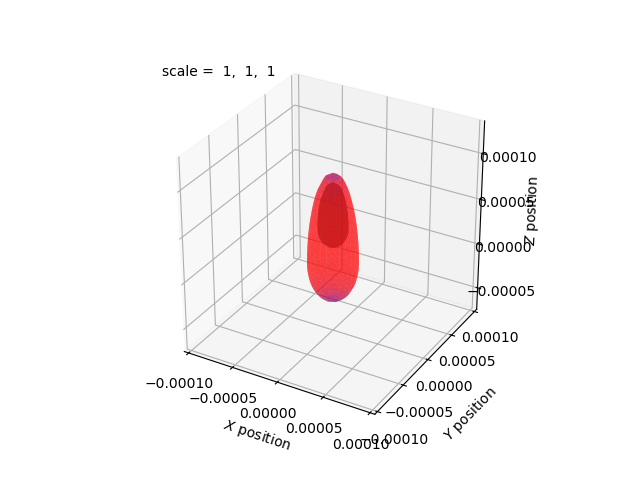

In [5]:
CEsurf = chimeraSpheroid(D=surf_pars.D,L1=surf_pars.L1,L2=surf_pars.L2,d=surf_pars.d,nlevels=surf_pars.nlevels)
CEincl = chimeraSpheroid(D=incl1_pars.D,L1=incl1_pars.L1,L2=incl1_pars.L2,d=incl1_pars.d,nlevels=incl1_pars.nlevels,translate=incl1_pars.translate)
Mnew = mrph.Morphology()
Mnew.check_normals = False
Mnew.gen_surface(vectors=CEsurf.vectors)
# materials parameter can be 'seawater', 'tissue', 'lipid' or 'calcite' 
Mnew.gen_inclusion(vectors=CEincl.vectors,material='freshwater',immersed_in=1)

figureM = pyplot.figure(num=57)
axesM = figureM.add_subplot(projection='3d')
Mnew.plot_layers(axes=axesM)

figureM.canvas.draw()
figureM.canvas.flush_events()
pyplot.pause(0.25)
#pyplot.ioff()

### Compute the fluid forces
Executing this cell will compute the geometry and fluid flow around the model larva. 

Depending on the number of triangle and the speed of your computer, it may take a few seconds to complete: 
- When it starts calculating, it prints out "Calculating inverse...". 
- When the calculation is complete, it prints out "Done calculating inverse."
- The output includes statistics like the magnitudes and centers of buoyancy and gravity.

**You need to run this just once for each larval shape. You do not need to rerun it unless you change the larval shape.**

In [6]:
button6 = widgets.Button(description="Calculate flow")
output6 = widgets.Output()

buttonsC = widgets.HBox([button6, output6])
display(buttonsC)

@output6.capture()
def on_button_clicked6(b):
    Mnew.body_calcs()
    Mnew.flow_calcs(surface_layer=1)
    
button6.on_click(on_button_clicked6)

## Saving a larval shape <a id='section_saveshape'></a>

In [7]:
# Create and display a FileChooser widget
fc_s = FileChooser()
fc_s.filter_pattern = '*.pickle'
fc_s.title = '<b>Choose a filename for this larval morphology:</b>'
fc_s.default_filename = 'new_morph.pickle'

display(fc_s)

FileChooser(path='/home/dg/EBP/quant-org-bio/subrepos/biomechanics/ChimeraSwim', filename='new_morph.pickle', …

In [8]:
button3 = widgets.Button(description="Save file")
output3 = widgets.Output()

buttonsS = widgets.HBox([button3, output3])
display(buttonsS)

@output3.capture()
def on_button_clicked3(b):
    with open(fc_s.selected, 'wb') as handle:
        #print(f'Saving morphology as {fc_s.selected}')
        Mnew.clear_big_arrays()
        pickle.dump(Mnew, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print(f'Saved morphology as {fc_s.selected}')

button3.on_click(on_button_clicked3)